# Problem Statement

In [152]:
# Import the required libraries
import os
import sys
import math
import torch
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate, KFold
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import shap
from datetime import datetime
from io import StringIO
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Understanding the Dataset

In [153]:
# Download 200k recent rows of 311 dataset using the API and store locally
def acquire_data(data_filename, limit=100000):
    
    dataset_url = f"https://data.cityofnewyork.us/resource/erm2-nwe9.csv?$limit={limit}&$order=created_date%20DESC"

    if os.path.exists(data_filename):
        print(f"Found local CSV: {data_filename}")
        df = pd.read_csv(data_filename, low_memory=False)
        source = "local"
    else:
        print("Attempting to download latest rows from Socrata API...")
        try:
            resp = requests.get(dataset_url, timeout=60)
            resp.raise_for_status()
            with open(data_filename, "wb") as f:
                f.write(resp.content)
            df = pd.read_csv(data_filename, low_memory=False)
            source = "downloaded"
        except Exception as e:
            print("Download failed:", e)
            raise RuntimeError("Please download manually and place the file locally.")
    print(f"Loaded {len(df):,} rows from {source}.")
    
    return df

In [154]:
data_filename='311_recent_100k.csv'
acquire_data(data_filename, limit=100000)
df = pd.read_csv('./'+ data_filename)
print(df.shape)
print(df.columns)

Found local CSV: 311_recent_100k.csv
Loaded 100,000 rows from local.
(100000, 41)
Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'location_type', 'incident_zip',
       'incident_address', 'street_name', 'cross_street_1', 'cross_street_2',
       'intersection_street_1', 'intersection_street_2', 'address_type',
       'city', 'landmark', 'facility_type', 'status', 'due_date',
       'resolution_description', 'resolution_action_updated_date',
       'community_board', 'bbl', 'borough', 'x_coordinate_state_plane',
       'y_coordinate_state_plane', 'open_data_channel_type',
       'park_facility_name', 'park_borough', 'vehicle_type',
       'taxi_company_borough', 'taxi_pick_up_location', 'bridge_highway_name',
       'bridge_highway_direction', 'road_ramp', 'bridge_highway_segment',
       'latitude', 'longitude', 'location'],
      dtype='object')


In [155]:
df.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,...,vehicle_type,taxi_company_borough,taxi_pick_up_location,bridge_highway_name,bridge_highway_direction,road_ramp,bridge_highway_segment,latitude,longitude,location
0,66750763,2025-11-07T03:18:35.000,NaN,DOT,Department of Transportation,Street Condition,Pothole,NaN,11419.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.682171,-73.831036,"\n, \n(40.68217129261496, -73.83103591998932)"
1,66749274,2025-11-07T03:18:03.000,NaN,DOT,Department of Transportation,Street Condition,Pothole,NaN,11419.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.683665,-73.825775,"\n, \n(40.68366484085658, -73.82577520658724)"
2,66740454,2025-11-07T03:17:22.000,NaN,DOT,Department of Transportation,Street Condition,Pothole,NaN,11434.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.663681,-73.771428,"\n, \n(40.66368101085791, -73.77142831921691)"
3,66746321,2025-11-07T03:16:41.000,NaN,DOT,Department of Transportation,Street Condition,Pothole,NaN,11434.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.662799,-73.769575,"\n, \n(40.66279898126321, -73.76957504824182)"
4,66741935,2025-11-07T02:36:30.000,NaN,DOT,Department of Transportation,Street Condition,Pothole,NaN,11235.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.583669,-73.948428,"\n, \n(40.58366903894329, -73.94842756199074)"


In [156]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 41 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   unique_key                      100000 non-null  int64  
 1   created_date                    100000 non-null  object 
 2   closed_date                     75337 non-null   object 
 3   agency                          100000 non-null  object 
 4   agency_name                     100000 non-null  object 
 5   complaint_type                  100000 non-null  object 
 6   descriptor                      98287 non-null   object 
 7   location_type                   86576 non-null   object 
 8   incident_zip                    98998 non-null   float64
 9   incident_address                96085 non-null   object 
 10  street_name                     96079 non-null   object 
 11  cross_street_1                  65322 non-null   object 
 12  cross_street_2   

In [157]:
# What date range does this dataset cover?
df["created_date"] = pd.to_datetime(df["created_date"], errors="coerce")
df["closed_date"] = pd.to_datetime(df["closed_date"], errors="coerce")
print(df["created_date"].min(), df["created_date"].max())

2025-10-28 15:14:46 2025-11-07 03:18:35


In [158]:
# Check Columns with high % of missing values (>75%) → likely candidates for dropping
df.isna().sum().sort_values(ascending=False)

taxi_company_borough              99932
facility_type                     99771
road_ramp                         99766
bridge_highway_direction          99714
due_date                          99518
bridge_highway_segment            99343
bridge_highway_name               99342
taxi_pick_up_location             98917
vehicle_type                      96063
landmark                          45560
intersection_street_1             39072
intersection_street_2             39009
cross_street_1                    34678
cross_street_2                    34629
closed_date                       24663
location_type                     13424
bbl                               10396
resolution_description             9404
resolution_action_updated_date     8537
city                               4217
street_name                        3921
incident_address                   3915
descriptor                         1713
longitude                          1219
location                           1219


# Cleaning and Transforming Data


In [159]:
#  Drop columns with >75% missing values
def drop_high_missing_columns(df, threshold=0.75):
    
    # Calculate the fraction of missing values per column
    missing_fraction = df.isna().mean()

    # Identify columns to drop
    cols_to_drop = missing_fraction[missing_fraction > threshold].index.tolist()

    print(f"Total columns before: {df.shape[1]}")
    print(f"Columns with >{int(threshold*100)}% missing: {len(cols_to_drop)}")
    if cols_to_drop:
        print("Dropped columns:", cols_to_drop)

    # Drop them
    df_cleaned = df.drop(columns=cols_to_drop)

    print(f" Columns after cleanup: {df_cleaned.shape[1]}")
    return df_cleaned


# Example usage:
df = drop_high_missing_columns(df, threshold=0.75)


Total columns before: 41
Columns with >75% missing: 9
Dropped columns: ['facility_type', 'due_date', 'vehicle_type', 'taxi_company_borough', 'taxi_pick_up_location', 'bridge_highway_name', 'bridge_highway_direction', 'road_ramp', 'bridge_highway_segment']
 Columns after cleanup: 32


In [160]:
#df.isna().sum().sort_values(ascending=False)

In [161]:
#df.info()

In [162]:
# Impute Missing Values in Mixed-Type Dataset
def impute_missing_values(df):
    
    df_imputed = df.copy()

    # Separate column types
    num_cols = df_imputed.select_dtypes(include=['float64', 'int64']).columns
    cat_cols = df_imputed.select_dtypes(include=['object']).columns

    print(f" Numeric columns to impute: {len(num_cols)}")
    print(f" Categorical columns to impute: {len(cat_cols)}")

    # Numeric: Median imputation
    num_imputer = SimpleImputer(strategy='median')
    df_imputed[num_cols] = num_imputer.fit_transform(df_imputed[num_cols])

    # Categorical: Most frequent (mode) imputation
    cat_imputer = SimpleImputer(strategy='most_frequent')
    df_imputed[cat_cols] = cat_imputer.fit_transform(df_imputed[cat_cols])

    print(" Missing value imputation complete.")
    return df_imputed

In [163]:
# Example usage:
df = impute_missing_values(df)

 Numeric columns to impute: 7
 Categorical columns to impute: 23
 Missing value imputation complete.


In [164]:
# Compute the target feature, response_time_hours,  using closed_date and created_date
def create_target(df):
    
    df = df.copy()

    # Convert to datetime
    df["created_date"] = pd.to_datetime(df["created_date"], errors="coerce")
    df["closed_date"] = pd.to_datetime(df["closed_date"], errors="coerce")

    # Calculate response time (in hours)
    df["response_time_hours"] = (df["closed_date"] - df["created_date"]).dt.total_seconds() / 3600

    # Drop invalid / negative / missing values
    before = len(df)
    df = df.dropna(subset=["response_time_hours"])
    df = df[df["response_time_hours"] >= 0]
    print(f" Target created: response_time_hours. Dropped {before - len(df)} invalid rows. Remaining: {len(df)}")

    return df

In [165]:
df = create_target(df)
df.head()

 Target created: response_time_hours. Dropped 24740 invalid rows. Remaining: 75260


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,...,borough,x_coordinate_state_plane,y_coordinate_state_plane,open_data_channel_type,park_facility_name,park_borough,latitude,longitude,location,response_time_hours
32,66742212.0,2025-11-07 01:54:31,2025-11-07 02:52:53,DHS,Department of Homeless Services,Homeless Person Assistance,Non-Chronic,Street/Sidewalk,10013.0,60 LAFAYETTE STREET,...,MANHATTAN,983605.0,200302.0,PHONE,Unspecified,MANHATTAN,40.716459,-74.002327,"\n, \n(40.716459431762694, -74.0023267359905)",0.972778
53,66739653.0,2025-11-07 01:41:17,2025-11-07 01:58:22,NYPD,New York City Police Department,Illegal Parking,Posted Parking Sign Violation,Street/Sidewalk,11694.0,123-10 OCEAN PROMENADE,...,QUEENS,1028160.0,149005.0,MOBILE,Unspecified,QUEENS,40.575552,-73.841936,"\n, \n(40.57555156030797, -73.84193566236333)",0.284722
72,66743777.0,2025-11-07 01:35:01,2025-11-07 02:05:10,DSNY,Department of Sanitation,Vendor Enforcement,Food Vendor,Street,10001.0,379 9 AVENUE,...,MANHATTAN,984945.0,213166.0,PHONE,Unspecified,MANHATTAN,40.751768,-73.997492,"\n, \n(40.751767940685404, -73.99749156803034)",0.502500
73,66750208.0,2025-11-07 01:34:57,2025-11-07 02:04:23,NYPD,New York City Police Department,Noise - Residential,Banging/Pounding,Residential Building/House,10025.0,216 WEST 102 STREET,...,MANHATTAN,993024.0,230072.0,MOBILE,Unspecified,MANHATTAN,40.798166,-73.968310,"\n, \n(40.79816614430284, -73.96831032698584)",0.490556
76,66745781.0,2025-11-07 01:33:57,2025-11-07 01:58:43,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,11414.0,85-18 149 AVENUE,...,QUEENS,1025985.0,183275.0,PHONE,Unspecified,QUEENS,40.669626,-73.849553,"\n, \n(40.669625907521294, -73.8495531953706)",0.412778


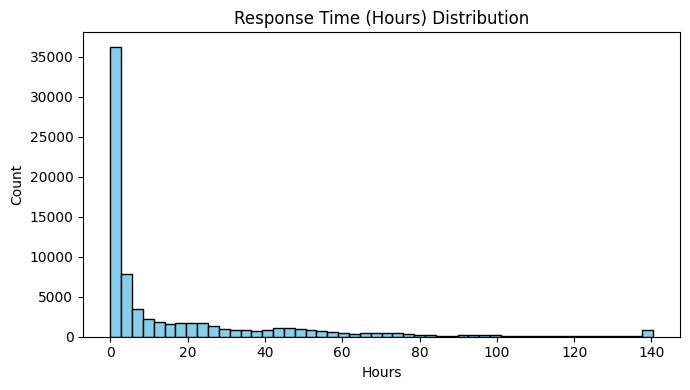

In [166]:
# Plot target distribution
plt.figure(figsize=(7, 4))
plt.hist(df["response_time_hours"].clip(upper=df["response_time_hours"].quantile(0.99)),bins=50, color="skyblue", edgecolor="black")
plt.title("Response Time (Hours) Distribution")
plt.xlabel("Hours")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [167]:
# Exploratory data analysis - Computes average, median, Min and Max response time for the training dataset.
def compute_average_response_time(train_df, target_col="response_time_hours"):
    
    try:
        avg_time = train_df[target_col].mean()
        median_time = train_df[target_col].median()
        max_time = train_df[target_col].max()
        min_time = train_df[target_col].min()

        print(f"Average Response Time: {avg_time:.2f} hours")
        print(f"Median Response Time:  {median_time:.2f} hours")
        print(f"Min Response Time: {min_time:.2f} hours | Max Response Time: {max_time:.2f} hours")

        return {
            "average_hours": avg_time,
            "median_hours": median_time,
            "min_hours": min_time,
            "max_hours": max_time
        }

    except Exception as e:
        print(f"Failed to compute average response time: {e}")
        return None


In [168]:
compute_average_response_time(df, target_col="response_time_hours")

Average Response Time: 17.27 hours
Median Response Time:  3.13 hours
Min Response Time: 0.00 hours | Max Response Time: 217.04 hours


{'average_hours': np.float64(17.271415515103197),
 'median_hours': np.float64(3.133472222222222),
 'min_hours': np.float64(0.0),
 'max_hours': np.float64(217.0388888888889)}

In [169]:
df.shape

(75260, 33)

# Feature Selection

In [186]:
# Feature Selection
# response_time_hours is what we’re trying to predict — can’t use it as input.
# A unique ID adds zero predictive value and may cause data leakage or overfitting.
# created_date At prediction time, we can use derived temporal features (hour, weekday, month), 
# but not the raw datetime, because MI treats it as a number, not time.
# closed_date Not available when the request is created — it’s determined after resolution. Using it leaks the target.
# due_date Typically derived from internal SLA systems and sometimes correlates strongly with response time (data leakage).
# resolution_action_updated_date and resolution_description also occurs after case closure, not available at request creation. Leaks target
# location is redundant with latitude, longitude, borough, etc. It’s a composite field that’s difficult to encode, 
# usefully without geospatial parsing.  We’ll instead use the structured components.
def select_features(df, target_col="response_time_hours", top_k=15):
    exclude_cols = [
        target_col, "unique_key", "closed_date",
        "due_date", "resolution_action_updated_date", "resolution_description", "location"
    ]

    candidate_features = [c for c in df.columns if c not in exclude_cols]
    print(f"Candidate features: {len(candidate_features)}")

    # Drop features with >50% missing
    missing_frac = df[candidate_features].isnull().mean()
    features = [c for c in candidate_features if missing_frac[c] < 0.5]
    features = [c for c in features if df[c].nunique() > 1]
   

    # Separate numeric & categorical
    num_feats = [c for c in features if pd.api.types.is_numeric_dtype(df[c])]
    cat_feats = [c for c in features if c not in num_feats]

    # Handle missing values (important!)
    df_prep = df[num_feats + cat_feats].copy()

    # Fill numeric NaNs with median
    for c in num_feats:
        if df_prep[c].isna().any():
            df_prep[c] = df_prep[c].fillna(df_prep[c].median())

    # Fill categorical NaNs with "Unknown"
    for c in cat_feats:
        df_prep[c] = df_prep[c].fillna("Unknown")

    # Encode categorical columns
    le = LabelEncoder()
    for c in cat_feats:
        try:
            df_prep[c] = le.fit_transform(df_prep[c].astype(str))
        except Exception:
            df_prep[c] = 0

    # Drop any residual NaNs
    df_prep = df_prep.dropna()

    # Compute Mutual Information safely
    # MI measures how much each feature actually helps predict the target
    # Keeping only the strongest features reduces overfitting
    # 15 is a widely used sweet spot for tabular prediction problems.
    # Mutual Information finds features that reduce uncertainty about the target by estimating:
    # distributions
    # entropy
    # conditional entropy
    # using a non-parametric, k-NN–based method.
    mi = mutual_info_regression(df_prep[features], df[target_col].loc[df_prep.index], random_state=42)
    mi_scores = pd.Series(mi, index=features).sort_values(ascending=False)

    top_features = mi_scores.head(top_k).index.tolist()

    print(f"After feature selection: {len(top_features)} usable features.")
    print("\n Top features by mutual information:\n", mi_scores.head(top_k))

    return top_features, mi_scores

In [172]:
selected, scores = select_features(df)
print("\n Selected features:\n", selected)
# Save only selected features + target column
final_cols = selected + ["response_time_hours"] # 15 + 1
df_filtered = df[final_cols].copy()
df_filtered.to_csv("311_recent_100k_processed.csv", index=False)

Candidate features: 27
After feature selection: 15 usable features.

 Top features by mutual information:
 complaint_type              0.709163
agency_name                 0.633597
agency                      0.630621
descriptor                  0.619755
created_date                0.582100
location_type               0.385681
intersection_street_2       0.371222
intersection_street_1       0.362878
landmark                    0.353851
cross_street_2              0.340967
cross_street_1              0.332397
y_coordinate_state_plane    0.317125
latitude                    0.316207
longitude                   0.310261
x_coordinate_state_plane    0.307363
dtype: float64

 Selected features:
 ['complaint_type', 'agency_name', 'agency', 'descriptor', 'created_date', 'location_type', 'intersection_street_2', 'intersection_street_1', 'landmark', 'cross_street_2', 'cross_street_1', 'y_coordinate_state_plane', 'latitude', 'longitude', 'x_coordinate_state_plane']


# Downloading other relevant dataset(New York weather dataset)

In [173]:
# Downloading other relevant dataset(New York weather dataset)
def fetch_openmeteo_weather(min_date, max_date, lat=40.7128, lon=-74.0060):
    url = (
        f"https://archive-api.open-meteo.com/v1/archive?"
        f"latitude={lat}&longitude={lon}"
        f"&start_date={min_date}&end_date={max_date}"
        f"&daily=temperature_2m_max,temperature_2m_min,precipitation_sum"
        f"&timezone=America%2FNew_York"
    )
    r = requests.get(url)
    r.raise_for_status()
    data = r.json()["daily"]
    df = pd.DataFrame(data)
    df.rename(columns={
        "time": "date",
        "temperature_2m_max": "temp_max",
        "temperature_2m_min": "temp_min",
        "precipitation_sum": "precipitation"
    }, inplace=True)
    df["date"] = pd.to_datetime(df["date"])
    df["temp_avg"] = (df["temp_max"] + df["temp_min"]) / 2
    df.to_csv("nyc_weather_daily.csv", index=False)
    print(f"Saved NYC weather data ({len(df):,} days) to nyc_weather_daily.csv")
    return df


# Merge the primary dataset with weather dataset

In [174]:
df = pd.read_csv("311_recent_100k_processed.csv", parse_dates=["created_date"])
min_date = df["created_date"].min().date()
max_date = df["created_date"].max().date()
print("Need weather from", min_date, "to", max_date)

weather_df = fetch_openmeteo_weather(min_date, max_date, lat=40.7128, lon=-74.0060)

weather_df.rename(columns={"time": "date",
            "temperature_2m_max": "temp_max",
            "temperature_2m_min": "temp_min",
            "precipitation_sum": "precipitation"
}, inplace=True)
        
weather_df["date"] = pd.to_datetime(weather_df["date"])
weather_df["temp_avg"] = (weather_df["temp_max"] + weather_df["temp_min"]) / 2
        
weather_df = weather_df[["date", "temp_max", "temp_min", "temp_avg", "precipitation"]]
weather_df.to_csv("nyc_weather_daily_clean.csv", index=False)
print(" NYC weather data saved to nyc_weather_daily_clean.csv")
print(weather_df.head())

df["complaint_date"] = pd.to_datetime(df["created_date"]).dt.date
weather_df["date"] = pd.to_datetime(weather_df["date"]).dt.date
        
df = df.merge(weather_df, how="left", left_on="complaint_date", right_on="date")

df.drop(columns=["date","complaint_date","created_date" ], inplace=True) # 15 + 1(target) - 1(created_date) + 4 = 19

print(df.shape)
print(df.columns)
df.to_csv("processed_and_merged.csv", index=False)

Need weather from 2025-10-28 to 2025-11-07
Saved NYC weather data (11 days) to nyc_weather_daily.csv
 NYC weather data saved to nyc_weather_daily_clean.csv
        date  temp_max  temp_min  temp_avg  precipitation
0 2025-10-28      12.2       4.1      8.15            0.0
1 2025-10-29      13.5       7.0     10.25            0.1
2 2025-10-30      16.4      10.7     13.55           44.4
3 2025-10-31      13.4       9.8     11.60            0.0
4 2025-11-01      14.3       7.5     10.90            0.0
(75260, 19)
Index(['complaint_type', 'agency_name', 'agency', 'descriptor',
       'location_type', 'intersection_street_2', 'intersection_street_1',
       'landmark', 'cross_street_2', 'cross_street_1',
       'y_coordinate_state_plane', 'latitude', 'longitude',
       'x_coordinate_state_plane', 'response_time_hours', 'temp_max',
       'temp_min', 'temp_avg', 'precipitation'],
      dtype='object')


# Selecting the Models and Model Training

In [175]:
# Check for CUDA
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
1
NVIDIA GeForce RTX 4050 Laptop GPU


In [176]:
# GPU Detection
def detect_gpu():
    gpu_info = {"torch": False, "cupy": False, "device": None}
    try:
        import torch
        gpu_info["torch"] = torch.cuda.is_available()
        if gpu_info["torch"]:
            gpu_info["device"] = torch.cuda.get_device_name(0)
    except Exception:
        pass
    try:
        import cupy
        _ = cupy.zeros((1,))
        gpu_info["cupy"] = True
    except Exception:
        pass   

    print(f"GPU detection results: {gpu_info}")
    return gpu_info
    
gpu_status = detect_gpu()

GPU detection results: {'torch': True, 'cupy': True, 'device': 'NVIDIA GeForce RTX 4050 Laptop GPU'}


In [177]:
# Preprocess the NYC 311 + Weather dataset
# Encode categorical variables
# Scale numeric variables
# Split into train/validation/test sets
def preprocess_data(df):    
    print("\n Starting data preprocessing...")
   
    # Define target and features
    
    target_col = "response_time_hours"
    X = df.drop(columns=[target_col])
    y = df[target_col]

    
    # Identify feature types
    
    categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
    numerical_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

    print(f" Categorical columns ({len(categorical_cols)}): {categorical_cols}")
    print(f" Numerical columns ({len(numerical_cols)}): {numerical_cols}")

    
    # Imputation & Encoding    
    # Categorical: fill missing with "Unknown" + one-hot encode

    from sklearn.preprocessing import OrdinalEncoder

    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
    ])

    # Numerical: fill missing with median + scale
    numerical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    # Combine into a column transformer
    preprocessor = ColumnTransformer(transformers=[
        ("num", numerical_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols)
    ])

    
    # Train / Validation / Test Split
   
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

    print(f"\n Dataset split:")
    print(f"   Train: {X_train.shape[0]:,} rows")
    print(f"   Val:   {X_val.shape[0]:,} rows")
    print(f"   Test:  {X_test.shape[0]:,} rows")

    
    # Fit the preprocessor
    
    print("\n Fitting preprocessing pipeline...")
    preprocessor.fit(X_train)

    # Transform datasets
    X_train_prep = preprocessor.transform(X_train)
    X_val_prep = preprocessor.transform(X_val)
    X_test_prep = preprocessor.transform(X_test)

    print(f" Preprocessing complete.")
    print(f" Transformed feature space: {X_train_prep.shape[1]} columns")

    return X_train_prep, X_val_prep, X_test_prep, y_train, y_val, y_test, preprocessor


In [178]:
# Model Training (multiple baseline models + CV + evaluation)
# LinearRegression, Ridge , LassoCV,  xgboost, lightgbm, catboost, MLP Regressor

# GPU detection (torch) to prefer GPU variants if available
def detect_gpu_available():
    try:
        import torch
        return torch.cuda.is_available()
    except Exception:
        return False

GPU_AVAILABLE = detect_gpu_available()
print("GPU available for model training (torch CUDA):", GPU_AVAILABLE)

# Scoring functions
def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

RMSE_SCORER = make_scorer(mean_squared_error, greater_is_better=False, squared=False) 


def evaluate_on_dataset(model, X, y):
    preds = model.predict(X)
    mae = mean_absolute_error(y, preds)
    rmse_val = rmse(y, preds)
    r2 = r2_score(y, preds)
    return {"mae": mae, "rmse": rmse_val, "r2": r2}

# Main routine
def train_and_compare_models(
    X_train, y_train,
    X_val, y_val,
    X_test, y_test,
    feature_names=None,
    cv_folds=5,
    random_state=42,
    use_gpu_if_possible=True
):
    results = []
    fitted_models = {}

    # Define cross-validation splitter
    # KFold prevents overfitting and gives robust performance metrics
    cv = KFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

    # 1) Linear Regression (OLS)
    print("\n>> Training LinearRegression (OLS)")
    lr = LinearRegression()
    # cross-validate (MAE, RMSE (neg), R2)
    cv_res = cross_validate(lr, X_train, y_train, cv=cv,
                            scoring={"mae": "neg_mean_absolute_error",
                                     "rmse": "neg_root_mean_squared_error",
                                     "r2": "r2"},
                            n_jobs=-1, return_train_score=False)
    lr.fit(X_train, y_train)
    fitted_models["LinearRegression"] = lr
    train_cv_mae = -np.mean(cv_res["test_mae"])
    train_cv_rmse = -np.mean(cv_res["test_rmse"])
    train_cv_r2 = np.mean(cv_res["test_r2"])
    val_metrics = evaluate_on_dataset(lr, X_val, y_val)
    test_metrics = evaluate_on_dataset(lr, X_test, y_test)
    results.append({
        "model": "LinearRegression",
        "cv_mae": train_cv_mae, "cv_rmse": train_cv_rmse, "cv_r2": train_cv_r2,
        "val_mae": val_metrics["mae"], "val_rmse": val_metrics["rmse"], "val_r2": val_metrics["r2"],
        "test_mae": test_metrics["mae"], "test_rmse": test_metrics["rmse"], "test_r2": test_metrics["r2"]
    })
    print("LinearRegression done. Val MAE:", val_metrics["mae"])

    # 2) Ridge (regularized linear)
    print("\n>> Training RidgeCV (alpha selection)")
    ridge = RidgeCV(alphas=np.logspace(-3, 3, 7), cv=cv)
    cv_res = cross_validate(ridge, X_train, y_train, cv=cv,
                            scoring={"mae": "neg_mean_absolute_error",
                                     "rmse": "neg_root_mean_squared_error",
                                     "r2": "r2"},
                            n_jobs=-1)
    ridge.fit(X_train, y_train)
    fitted_models["RidgeCV"] = ridge
    train_cv_mae = -np.mean(cv_res["test_mae"])
    train_cv_rmse = -np.mean(cv_res["test_rmse"])
    train_cv_r2 = np.mean(cv_res["test_r2"])
    val_metrics = evaluate_on_dataset(ridge, X_val, y_val)
    test_metrics = evaluate_on_dataset(ridge, X_test, y_test)
    results.append({
        "model": "RidgeCV",
        "cv_mae": train_cv_mae, "cv_rmse": train_cv_rmse, "cv_r2": train_cv_r2,
        "val_mae": val_metrics["mae"], "val_rmse": val_metrics["rmse"], "val_r2": val_metrics["r2"],
        "test_mae": test_metrics["mae"], "test_rmse": test_metrics["rmse"], "test_r2": test_metrics["r2"]
    })
    print("RidgeCV done. Selected alpha:", ridge.alpha_)

    # 3) LassoCV
    print("\n>> Training LassoCV (alpha selection)")
    lasso = LassoCV(alphas=None, cv=cv, random_state=random_state, n_jobs=-1, max_iter=5000)
    try:
        cv_res = cross_validate(lasso, X_train, y_train, cv=cv,
                                scoring={"mae": "neg_mean_absolute_error",
                                         "rmse": "neg_root_mean_squared_error",
                                         "r2": "r2"},
                                n_jobs=-1)
        lasso.fit(X_train, y_train)
        fitted_models["LassoCV"] = lasso
        train_cv_mae = -np.mean(cv_res["test_mae"])
        train_cv_rmse = -np.mean(cv_res["test_rmse"])
        train_cv_r2 = np.mean(cv_res["test_r2"])
        val_metrics = evaluate_on_dataset(lasso, X_val, y_val)
        test_metrics = evaluate_on_dataset(lasso, X_test, y_test)
        results.append({
            "model": "LassoCV",
            "cv_mae": train_cv_mae, "cv_rmse": train_cv_rmse, "cv_r2": train_cv_r2,
            "val_mae": val_metrics["mae"], "val_rmse": val_metrics["rmse"], "val_r2": val_metrics["r2"],
            "test_mae": test_metrics["mae"], "test_rmse": test_metrics["rmse"], "test_r2": test_metrics["r2"]
        })
        print("LassoCV done. Selected alpha:", lasso.alpha_)
    except Exception as e:
        print("LassoCV failed:", e)

   
    # 4) XGBoost (GPU if available and package installed)
    print("\n>> Training XGBoost")
    xgb_params = dict(n_estimators=500, random_state=random_state)
    if use_gpu_if_possible and GPU_AVAILABLE:
        xgb_params.update({"tree_method": "hist", "predictor": "gpu_predictor"})
        print("Using XGBoost GPU mode.")
    else:
        print("Using XGBoost CPU mode.")
    xgb_model = xgb.XGBRegressor(**xgb_params)
    cv_res = cross_validate(xgb_model, X_train, y_train, cv=cv,scoring={"mae": "neg_mean_absolute_error",
                                         "rmse": "neg_root_mean_squared_error",
                                         "r2": "r2"},
                                n_jobs=-1)
    xgb_model.fit(X_train, y_train, verbose=False)
    fitted_models["XGBoost"] = xgb_model
    train_cv_mae = -np.mean(cv_res["test_mae"])
    train_cv_rmse = -np.mean(cv_res["test_rmse"])
    train_cv_r2 = np.mean(cv_res["test_r2"])
    val_metrics = evaluate_on_dataset(xgb_model, X_val, y_val)
    test_metrics = evaluate_on_dataset(xgb_model, X_test, y_test)
    results.append({
            "model": "XGBoost",
            "cv_mae": train_cv_mae, "cv_rmse": train_cv_rmse, "cv_r2": train_cv_r2,
            "val_mae": val_metrics["mae"], "val_rmse": val_metrics["rmse"], "val_r2": val_metrics["r2"],
            "test_mae": test_metrics["mae"], "test_rmse": test_metrics["rmse"], "test_r2": test_metrics["r2"]
    })
    print("XGBoost done. Val MAE:", val_metrics["mae"])
    
    
        

    # 5) LightGBM
    print("\n>> Training LightGBM")
    lgb_params = {"n_estimators": 1000, "random_state": random_state}
    if use_gpu_if_possible and GPU_AVAILABLE:
        try:
            # newer LightGBM uses device="gpu" or device_type parameter
            lgb_model = lgb.LGBMRegressor(device="gpu", **lgb_params)
            print("Using LightGBM GPU mode.")
        except Exception:
            lgb_model = lgb.LGBMRegressor(**lgb_params)
            print("Falling back to LightGBM CPU mode.")
    else:
        lgb_model = lgb.LGBMRegressor(**lgb_params)
        print("Using LightGBM CPU mode.")
    cv_res = cross_validate(lgb_model, X_train, y_train, cv=cv,
                                scoring={"mae": "neg_mean_absolute_error",
                                         "rmse": "neg_root_mean_squared_error",
                                         "r2": "r2"},
                                n_jobs=-1)
    lgb_model.fit(X_train, y_train)
    fitted_models["LightGBM"] = lgb_model
    train_cv_mae = -np.mean(cv_res["test_mae"])
    train_cv_rmse = -np.mean(cv_res["test_rmse"])
    train_cv_r2 = np.mean(cv_res["test_r2"])
    val_metrics = evaluate_on_dataset(lgb_model, X_val, y_val)
    test_metrics = evaluate_on_dataset(lgb_model, X_test, y_test)
    results.append({
            "model": "LightGBM",
            "cv_mae": train_cv_mae, "cv_rmse": train_cv_rmse, "cv_r2": train_cv_r2,
            "val_mae": val_metrics["mae"], "val_rmse": val_metrics["rmse"], "val_r2": val_metrics["r2"],
            "test_mae": test_metrics["mae"], "test_rmse": test_metrics["rmse"], "test_r2": test_metrics["r2"]
    })
    print("LightGBM done. Val MAE:", val_metrics["mae"])
   
        
    

    # 6) CatBoost
    print("\n>> Training CatBoost")
    try:
        if use_gpu_if_possible and GPU_AVAILABLE:
            cat = CatBoostRegressor(task_type="GPU", iterations=1000, random_state=random_state, verbose=0)
            print("Using CatBoost GPU mode.")
        else:
            cat = CatBoostRegressor(task_type="CPU", iterations=1000, random_state=random_state, verbose=0)
            # cross_validate does not support CatBoost easily due to verbose; do manual CV or skip CV and do fit
            # here we'll do a simple CV via cross_val_score wrapper if possible
        cv_res = cross_validate(cat, X_train, y_train, cv=cv,
                                    scoring={"mae": "neg_mean_absolute_error",
                                             "rmse": "neg_root_mean_squared_error",
                                             "r2": "r2"},
                                    n_jobs=-1)
        cat.fit(X_train, y_train, verbose=False)
        fitted_models["CatBoost"] = cat
        train_cv_mae = -np.mean(cv_res["test_mae"])
        train_cv_rmse = -np.mean(cv_res["test_rmse"])
        train_cv_r2 = np.mean(cv_res["test_r2"])
        val_metrics = evaluate_on_dataset(cat, X_val, y_val)
        test_metrics = evaluate_on_dataset(cat, X_test, y_test)
        results.append({
                "model": "CatBoost",
                "cv_mae": train_cv_mae, "cv_rmse": train_cv_rmse, "cv_r2": train_cv_r2,
                "val_mae": val_metrics["mae"], "val_rmse": val_metrics["rmse"], "val_r2": val_metrics["r2"],
                "test_mae": test_metrics["mae"], "test_rmse": test_metrics["rmse"], "test_r2": test_metrics["r2"]
        })
        print("CatBoost done. Val MAE:", val_metrics["mae"])
    except Exception as e:
        print("CatBoost training failed:", e)
    
    
        

    # 7) MLPRegressor (neural network, optional)
    print("\n>> Training MLPRegressor (neural network, optional)")
    mlp = MLPRegressor(hidden_layer_sizes=(100,50), max_iter=500, random_state=random_state)
    try:
        cv_res = cross_validate(mlp, X_train, y_train, cv=cv,
                                scoring={"mae": "neg_mean_absolute_error",
                                         "rmse": "neg_root_mean_squared_error",
                                         "r2": "r2"},
                                n_jobs=-1)
        mlp.fit(X_train, y_train)
        fitted_models["MLP"] = mlp
        train_cv_mae = -np.mean(cv_res["test_mae"])
        train_cv_rmse = -np.mean(cv_res["test_rmse"])
        train_cv_r2 = np.mean(cv_res["test_r2"])
        val_metrics = evaluate_on_dataset(mlp, X_val, y_val)
        test_metrics = evaluate_on_dataset(mlp, X_test, y_test)
        results.append({
            "model": "MLP",
            "cv_mae": train_cv_mae, "cv_rmse": train_cv_rmse, "cv_r2": train_cv_r2,
            "val_mae": val_metrics["mae"], "val_rmse": val_metrics["rmse"], "val_r2": val_metrics["r2"],
            "test_mae": test_metrics["mae"], "test_rmse": test_metrics["rmse"], "test_r2": test_metrics["r2"]
        })
        print("MLP done. Val MAE:", val_metrics["mae"])
    except Exception as e:
        print("MLP training failed:", e)

    # Create DataFrame of results
    results_df = pd.DataFrame(results).sort_values(by="val_mae")
    # Round numeric columns for readability
    numeric_cols = [c for c in results_df.columns if c not in ["model"]]
    results_df[numeric_cols] = results_df[numeric_cols].round(4)

    print("\n=== Model comparison (sorted by val MAE) ===")
    print(results_df.reset_index(drop=True).to_string(index=False))

    return results_df, fitted_models



GPU available for model training (torch CUDA): True


In [179]:
# train test split
X_train_prep, X_val_prep, X_test_prep, y_train, y_val, y_test, preprocessor = preprocess_data(df)
feature_names = preprocessor.get_feature_names_out()
print(feature_names)


 Starting data preprocessing...
 Categorical columns (10): ['complaint_type', 'agency_name', 'agency', 'descriptor', 'location_type', 'intersection_street_2', 'intersection_street_1', 'landmark', 'cross_street_2', 'cross_street_1']
 Numerical columns (8): ['y_coordinate_state_plane', 'latitude', 'longitude', 'x_coordinate_state_plane', 'temp_max', 'temp_min', 'temp_avg', 'precipitation']

 Dataset split:
   Train: 52,682 rows
   Val:   11,289 rows
   Test:  11,289 rows

 Fitting preprocessing pipeline...
 Preprocessing complete.
 Transformed feature space: 18 columns
['num__y_coordinate_state_plane' 'num__latitude' 'num__longitude'
 'num__x_coordinate_state_plane' 'num__temp_max' 'num__temp_min'
 'num__temp_avg' 'num__precipitation' 'cat__complaint_type'
 'cat__agency_name' 'cat__agency' 'cat__descriptor' 'cat__location_type'
 'cat__intersection_street_2' 'cat__intersection_street_1' 'cat__landmark'
 'cat__cross_street_2' 'cat__cross_street_1']


In [180]:
print("\n Starting model training and comparison...\n")
results_df, models = train_and_compare_models(
            X_train_prep, y_train,
            X_val_prep, y_val,
            X_test_prep, y_test,
            feature_names=feature_names,
            cv_folds=5,
            random_state=42,
            use_gpu_if_possible=True
)
print("\n=== Model Comparison Summary ===")
print(results_df.to_string(index=False))
    
# Get the best model (lowest validation MAE)
best_model_name = results_df.sort_values("val_mae").iloc[0]["model"]
best_model = models[best_model_name]
    
print(f"\n Best Model: {best_model_name}")
print(best_model)

       
# Save best model

joblib.dump(best_model, f"best_model_{best_model_name}.pkl")
joblib.dump(preprocessor, "preprocessor.pkl")
    
print(f"\n Saved {best_model_name} and preprocessor for future use.")


 Starting model training and comparison...


>> Training LinearRegression (OLS)
LinearRegression done. Val MAE: 16.328882617986146

>> Training RidgeCV (alpha selection)
RidgeCV done. Selected alpha: 100.0

>> Training LassoCV (alpha selection)
LassoCV done. Selected alpha: 4.516080396328248

>> Training XGBoost
Using XGBoost GPU mode.
XGBoost done. Val MAE: 10.096483775512018

>> Training LightGBM
Using LightGBM GPU mode.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2714
[LightGBM] [Info] Number of data points in the train set: 52682, number of used features: 18
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4050 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 18 dense feature groups (1.00 MB) transferred to GPU in 0.003708 secs. 0 sparse feature groups
[LightGBM] [Info] Start training f

In [181]:
# tune best model found
def tune_best_model(model_name, base_model, X_train, y_train, X_val, y_val, X_test, y_test, use_gpu=True):
    
    print(f"\n Starting hyperparameter tuning for: {model_name.upper()}")  
    
    # Define model-specific grids    
    param_grids = {}
    
    # XGBoost
    param_grids["xgboost"] = {
        "n_estimators": [300, 500],
        "max_depth": [6, 8, 10],
        "learning_rate": [0.05, 0.1],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
        "min_child_weight": [1, 3]
    }

    # LightGBM
    param_grids["lightgbm"] = {
        "n_estimators": [300, 500],
        "num_leaves": [31, 63, 127],
        "learning_rate": [0.05, 0.1],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0]
    }

    # CatBoost
    param_grids["catboost"] = {
        "iterations": [300, 500],
        "depth": [6, 8, 10],
        "learning_rate": [0.05, 0.1],
        "l2_leaf_reg": [1, 3, 5]
    }

    
    # Model selection setup
    
    print("Model Name:", model_name)
    model_key = model_name.lower().replace(" ", "_")
    print("Model Key:", model_key)

    if model_key not in param_grids:
        print(f" No grid defined for '{model_name}'. Using base model as-is.")
        best_model = base_model
    else:
        param_grid = param_grids[model_key]

        
        # Instantiate model by type
        
        if model_key == "xgboost":
            import xgboost as xgb
            base_model = xgb.XGBRegressor(
                objective="reg:squarederror",
                tree_method="gpu_hist" if use_gpu else "hist",
                random_state=42
            )

        elif model_key == "lightgbm":
            import lightgbm as lgb
            base_model = lgb.LGBMRegressor(
                device="gpu" if use_gpu else "cpu",
                random_state=42
            )

        elif model_key == "catboost":
            from catboost import CatBoostRegressor
            base_model = CatBoostRegressor(
                task_type="GPU" if use_gpu else "CPU",
                random_seed=42,
                silent=True
            )

        
        # Grid Search
       
        print(f" Running grid search for {model_name}...")

        grid_search = GridSearchCV(
            estimator=base_model,
            param_grid=param_grid,
            scoring="neg_mean_absolute_error",
            cv=3,
            verbose=2,
            n_jobs=-1
        )

        grid_search.fit(X_train, y_train)

        print(f"\n Best Params for {model_name}: {grid_search.best_params_}")
        print(f" Best CV MAE: {-grid_search.best_score_:.4f}")

        
        # Retrain with best params
        
        X_full_train = np.vstack([X_train, X_val])
        y_full_train = np.concatenate([y_train, y_val])

        best_model = grid_search.best_estimator_
        best_model.fit(X_full_train, y_full_train)

    
    # Final Evaluation

    print(f"\n Evaluating tuned {model_name.upper()} on test data...")
    y_pred_test = best_model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2 = r2_score(y_test, y_pred_test)

    print(f"\n Final Test Results ({model_name.upper()}):")
    print(f"MAE  = {mae:.4f}")
    print(f"RMSE = {rmse:.4f}")
    print(f"R²   = {r2:.4f}")

    
    # Save Model
    
    joblib.dump(best_model, f"best_{model_key}_tuned.pkl")
    print(f" Tuned model saved as best_{model_key}_tuned.pkl")

    return best_model, {"mae": mae, "rmse": rmse, "r2": r2}


In [182]:
# Call tuning + evaluation
final_model, final_metrics = tune_best_model(
            model_name=best_model_name,
            base_model=best_model,
            X_train=X_train_prep,
            y_train=y_train,
            X_val=X_val_prep,
            y_val=y_val,
            X_test=X_test_prep,
            y_test=y_test,
            use_gpu=True
        )


 Starting hyperparameter tuning for: LIGHTGBM
Model Name: LightGBM
Model Key: lightgbm
 Running grid search for LightGBM...
Fitting 3 folds for each of 48 candidates, totalling 144 fits
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2714
[LightGBM] [Info] Number of data points in the train set: 52682, number of used features: 18
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4050 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 18 dense feature groups (1.00 MB) transferred to GPU in 0.003386 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 17.180313

 Best Params for LightGBM: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'n_estimators': 500, 'num_leaves': 127, 'subsample': 1.0}
 Best CV MAE: 8.9418
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Tot

In [183]:
# Fetches 10 most recent NYC 311 complaints, preprocesses them using saved preprocessor,
# loads best model, predicts response time, and saves results.
def fetch_and_predict_latest_complaints(model_path, limit , preprocessor_path, output_csv="latest_predictions.csv"):
    
    try:
        print(" Fetching latest NYC 311 complaints...")

        # NYC Open Data 311 API endpoint
        api_url = f"https://data.cityofnewyork.us/resource/erm2-nwe9.csv?$limit={limit}&$order=created_date DESC"
        response = requests.get(api_url)
        response.raise_for_status()

        df_latest = pd.read_csv(StringIO(response.text))
        print(f" Fetched {len(df_latest)} latest records.")

        # --- Keep only relevant columns used in training ---
        expected_features = [
            'resolution_description', 'complaint_type', 'descriptor', 'agency',
            'agency_name', 'location_type', 'intersection_street_2',
            'intersection_street_1', 'landmark', 'cross_street_2', 'cross_street_1',
            'y_coordinate_state_plane', 'latitude', 'longitude',
            'temp_max', 'temp_min', 'temp_avg', 'precipitation'
        ]
        
        id_col = "unique_key" if "unique_key" in df_latest.columns else "row_number"
        if id_col not in df_latest.columns:
            df_latest[id_col] = range(1, len(df_latest) + 1)

        # --- Merge with recent NYC weather data if available ---
        try:
            weather_df = pd.read_csv("nyc_weather_daily_clean.csv", parse_dates=["date"])

            # Ensure created_date is datetime
            df_latest["created_date"] = pd.to_datetime(df_latest["created_date"], errors="coerce")
        
            # Convert both sides to datetime.date for merge consistency
            df_latest["complaint_date"] = df_latest["created_date"].dt.date
            weather_df["date"] = pd.to_datetime(weather_df["date"], errors="coerce").dt.date
        
            # Merge safely
            df_latest = df_latest.merge(
                weather_df,
                left_on="complaint_date",
                right_on="date",
                how="left"
            )
        
            print(" Weather data merged successfully.")
        except Exception as e:
            print(f" Weather merge skipped: {e}")

        # --- Select only expected columns available ---
        available_cols = [col for col in expected_features if col in df_latest.columns]
        X_new = df_latest[available_cols].copy()

        print(f" Using {len(available_cols)} features for prediction.")

        # --- Load preprocessor and model ---
        preprocessor = joblib.load(preprocessor_path)
        model = joblib.load(model_path)

        # --- Apply preprocessing ---
        X_new_prep = preprocessor.transform(X_new)

        # --- Predict response time ---
        preds = model.predict(X_new_prep)
        df_latest["predicted_response_time_hours"] = preds

        # --- Save results with unique key and prediction ---
        df_latest[[id_col, "created_date", "complaint_type", "agency", "predicted_response_time_hours"]] \
            .to_csv(output_csv, index=False)

        print(f" Predictions saved to {output_csv}")
        print(df_latest[[id_col, "complaint_type", "predicted_response_time_hours"]].head())

        return df_latest

    except Exception as e:
        print(f" Pipeline failed: {e}")
        return None


In [184]:
# Prediction on 10 rows of latest data 
limit=10
latest_df = fetch_and_predict_latest_complaints(model_path="best_lightgbm_tuned.pkl",limit = limit, preprocessor_path="preprocessor.pkl")

 Fetching latest NYC 311 complaints...
 Fetched 10 latest records.
 Weather data merged successfully.
 Using 18 features for prediction.
 Pipeline failed: columns are missing: {'x_coordinate_state_plane'}


Initializing SHAP explainability analysis...

 Starting data preprocessing...
 Categorical columns (10): ['complaint_type', 'agency_name', 'agency', 'descriptor', 'location_type', 'intersection_street_2', 'intersection_street_1', 'landmark', 'cross_street_2', 'cross_street_1']
 Numerical columns (8): ['y_coordinate_state_plane', 'latitude', 'longitude', 'x_coordinate_state_plane', 'temp_max', 'temp_min', 'temp_avg', 'precipitation']

 Dataset split:
   Train: 52,682 rows
   Val:   11,289 rows
   Test:  11,289 rows

 Fitting preprocessing pipeline...
 Preprocessing complete.
 Transformed feature space: 18 columns
Creating SHAP explainer...
Computing SHAP values...

Calculating Top 10 Most Important Features Using SHAP...

=== Top 10 Most Important Features ===
                      feature  mean_abs_shap
                  cat__agency       8.155888
             cat__agency_name       6.948782
           cat__location_type       3.486786
          cat__complaint_type       2.363948
     

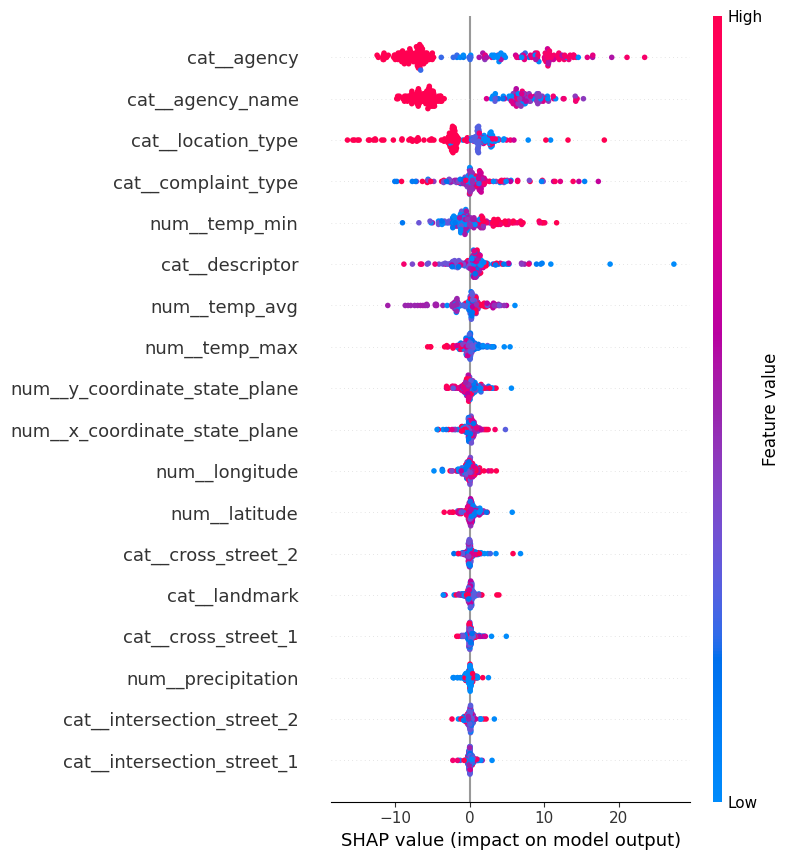

In [185]:
# SHAP explainability analysis
print("Initializing SHAP explainability analysis...")
best_model = joblib.load("best_lightgbm_tuned.pkl")

# Load your processed data
df = pd.read_csv('processed_and_merged.csv')

# Preprocess
X_train_prep, X_val_prep, X_test_prep, y_train, y_val, y_test, preprocessor = preprocess_data(df)

# Get feature names and rebuild DataFrame
feature_names = preprocessor.get_feature_names_out()
X_test_df = pd.DataFrame(X_test_prep, columns=feature_names)

# Take a small random sample for SHAP (200 rows)
X_sample = X_test_df.sample(200, random_state=42)

# Create SHAP explainer for lightGBM
print("Creating SHAP explainer...")
explainer = shap.TreeExplainer(best_model)

# Compute SHAP values
print("Computing SHAP values...")
shap_values = explainer.shap_values(X_sample)

# ==== NEW CODE: PRINT TOP 10 MOST IMPORTANT FEATURES ====
print("\nCalculating Top 10 Most Important Features Using SHAP...")
import numpy as np
import pandas as pd

# Mean absolute SHAP value for each feature
shap_importance = np.abs(shap_values).mean(axis=0)

importance_df = pd.DataFrame({
    "feature": feature_names,
    "mean_abs_shap": shap_importance
}).sort_values("mean_abs_shap", ascending=False)

# Print Top 10
print("\n=== Top 10 Most Important Features ===")
print(importance_df.head(10).to_string(index=False))

# Optional: Save importance to CSV
importance_df.to_csv("shap_feature_importance.csv", index=False)
print("\nFeature importance saved to shap_feature_importance.csv")

# ==== END NEW CODE ====

# Plot global feature importance
print("\nPlotting SHAP summary plot...")
shap.summary_plot(shap_values, X_sample)
